In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
import tensorflow as tf # print(tf.__version__) 2.17.1
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)


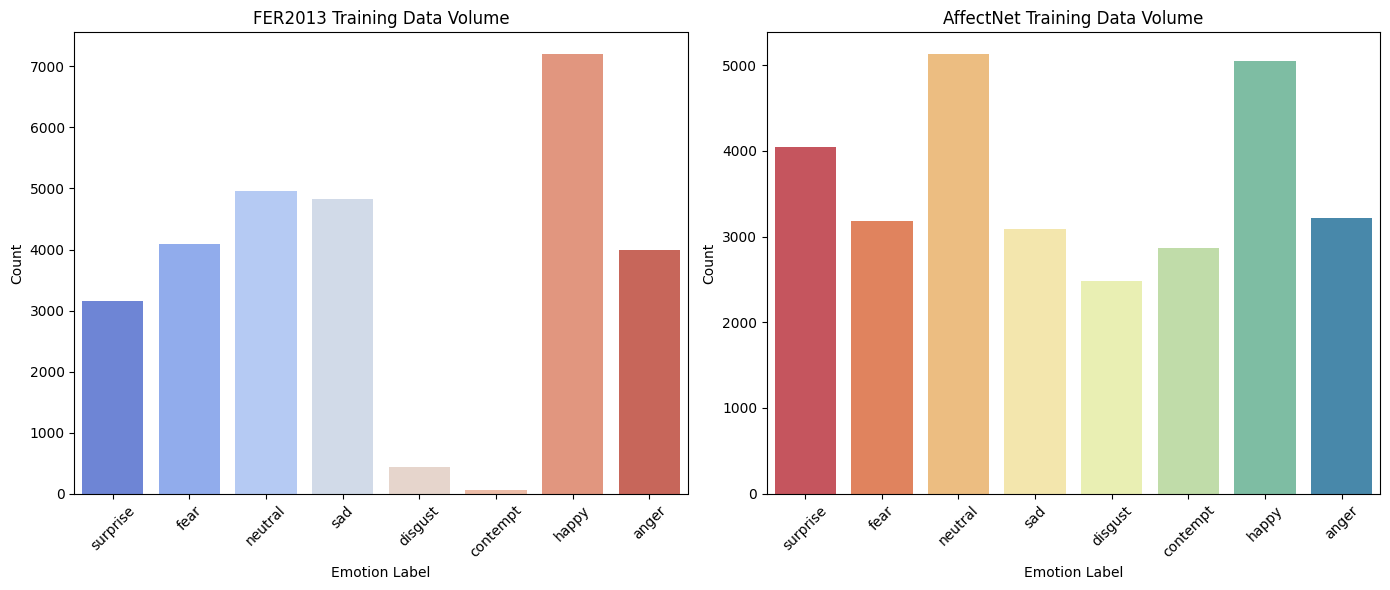

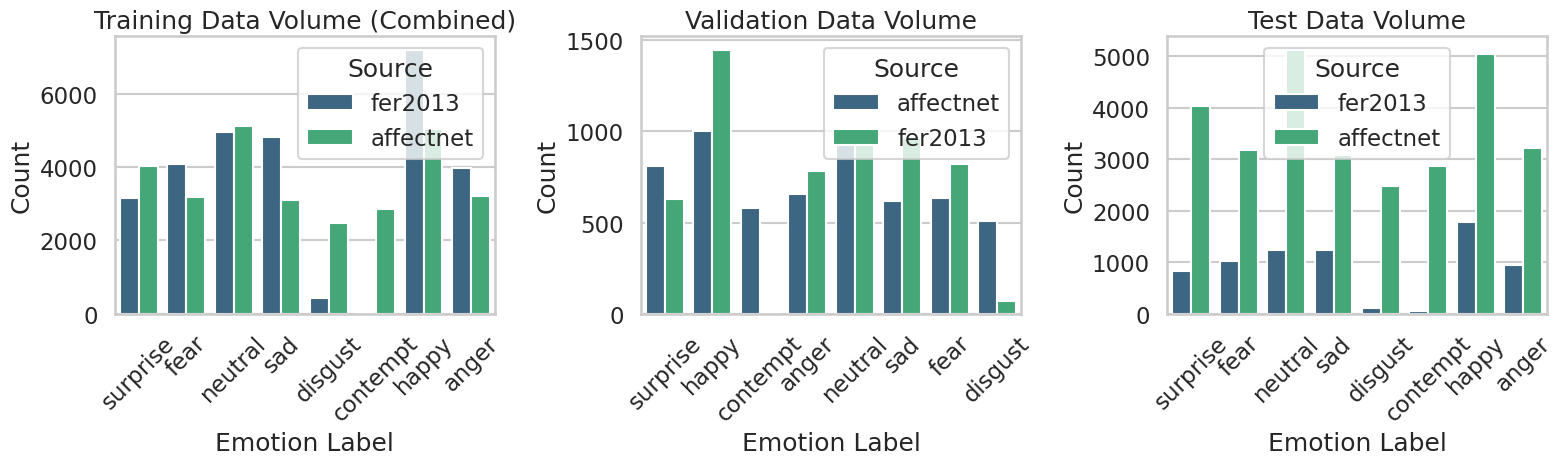

In [ ]:
# Version 5.0

import os
import glob
import math
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import logging
logging.basicConfig(level=logging.INFO)
tf.get_logger().setLevel(logging.INFO)

import gc
class MemoryCleanup(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()


# =============================================================================
# Define key parameters
# =============================================================================
img_size = 96         # We upscale FER images to 96x96
batch_size = 16
epochs = 10

# =============================================================================
# Learning Rate Finder Callback (Fixed)
# =============================================================================
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-2, steps=100):
        super(LRFinder, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []
        self.losses = []
        
    def on_train_begin(self, logs=None):
        # Use optimizer.learning_rate (compatible with LossScaleOptimizer)
        self.original_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.min_lr)
        self.optimizer = self.model.optimizer
    
    def on_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(self.optimizer.learning_rate)
        self.lrs.append(lr)
        self.losses.append(logs.get('loss'))
        new_lr = lr * (self.max_lr / self.min_lr) ** (1/self.steps)
        tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
        if batch >= self.steps:
            self.model.stop_training = True
            
    def on_train_end(self, logs=None):
        tf.keras.backend.set_value(self.optimizer.learning_rate, self.original_lr)

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure: root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")   # Case-sensitive!
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# Additional Plots: Separate by Source (Optional)
fer_df = train_df_full[train_df_full["source"] == "fer2013"]
aff_df = train_df_full[train_df_full["source"] == "affectnet"]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x="label", data=fer_df, palette="coolwarm")
plt.title("FER2013 Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x="label", data=aff_df, palette="Spectral")
plt.title("AffectNet Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# =============================================================================
# X. Visualization Code for DataFrames
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for a beautiful design.
sns.set(style="whitegrid", context="talk", palette="viridis")

# Plot 1: Training Data (Combined by Source)
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.countplot(x="label", hue="source", data=train_df_full, palette="viridis")
plt.title("Training Data Volume (Combined)")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Source")

# Plot 2: Validation Data (Combined by Source)
plt.subplot(1, 3, 2)
if "source" in val_df.columns:
    sns.countplot(x="label", hue="source", data=val_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=val_df, palette="viridis")
plt.title("Validation Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Plot 3: Test Data
plt.subplot(1, 3, 3)
if "source" in test_df.columns:
    sns.countplot(x="label", hue="source", data=test_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=test_df, palette="viridis")
plt.title("Test Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. Source-Specific Augmentation Functions
# =============================================================================
def apply_fer_augmentations(img):
    # Gentle augmentations for low-res FER2013 images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img

def apply_affectnet_augmentations(img):
    # Stronger augmentations for high-res AffectNet images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img

def augment_based_on_source(img, source):
    # Source-aware augmentation: assume img is a tensor in [0,1]
    if source == "fer2013":
        img = tf.image.rgb_to_grayscale(img)  # Ensure it's grayscale
        img = apply_fer_augmentations(img)
    else:
        img = apply_affectnet_augmentations(img)
    return img

# =============================================================================
# 5. Create Separate Generators for FER2013 and AffectNet
# =============================================================================
# Create a simpler, more robust training loop
# First, simplify your dataset creation

classes = sorted(train_df_full["label"].unique())

train_datagen = ImageDataGenerator(
    rescale=1./255
    #preprocessing_function=lambda x: np.repeat(x, 3, axis=-1) if x.shape[-1] == 1 else x
)

simple_train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",  # Use rgb for all images to simplify
    class_mode="categorical",
    classes=classes,
    batch_size=16,  # Reduced batch size
    shuffle=True
)

# Split the training DataFrame by source
fer_train_df = train_df[train_df["source"] == "fer2013"]
aff_train_df = train_df[train_df["source"] == "affectnet"]

# For FER2013: load as grayscale with gentle augmentation.
fer_aug_params = {
    "rescale": 1./255,
    "rotation_range": 15,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "brightness_range": [0.8, 1.2]
}
fer_datagen = ImageDataGenerator(**fer_aug_params)
fer_gen = fer_datagen.flow_from_dataframe(
    dataframe=fer_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    classes=classes,
    batch_size=32,
    shuffle=True
)

# For AffectNet: load as RGB with stronger augmentation.
aff_aug_params = {
    "rescale": 1./255,
    "rotation_range": 30,  # Reduced from 40
    "brightness_range": [0.7, 1.3],  # Reduced from [0.5, 1.5]
    "zoom_range": 0.1  # Reduced from 0.2
}
aff_datagen = ImageDataGenerator(**aff_aug_params)
aff_gen = aff_datagen.flow_from_dataframe(
    dataframe=aff_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    classes=classes,
    batch_size=32,
    shuffle=True
)

#######################################################################################
# If your images are grayscale and need to be converted to RGB, add this:
def convert_grayscale_to_rgb(batch_x, batch_y):
    # If the last dimension is 1, repeat it 3 times
    if batch_x.shape[-1] == 1:
        batch_x = np.repeat(batch_x, 3, axis=-1)
    return batch_x, batch_y

# Create a wrapper for your generator
def rgb_generator_wrapper(gen):
    for batch_x, batch_y in gen:
        yield convert_grayscale_to_rgb(batch_x, batch_y)

# Use the wrapped generator
rgb_train_gen = rgb_generator_wrapper(simple_train_gen)

#######################################################################################

# Calculate steps for each dataset.
steps_fer = math.ceil(len(fer_train_df) / 32)  # 22986/32=719
steps_aff = math.ceil(len(aff_train_df) / 32)  # 23209/32=726
steps_per_epoch = steps_fer + steps_aff        # 1445

#steps_fer = math.ceil(fer_train_df.shape[0] / 32)
#steps_aff = math.ceil(aff_train_df.shape[0] / 32)
#steps_per_epoch = steps_fer + steps_aff
#print(f"Steps per epoch: {steps_per_epoch}")

# After splitting in Section 3:
print(f"Train samples: {len(train_df)}")  # Should be ~36k (80% of 46k)
print(f"FER samples: {len(fer_train_df)}")  # ~18k (80% of 23k)
print(f"AffectNet samples: {len(aff_train_df)}")  # ~18k (80% of 23k)

# =============================================================================
# 6. Enhanced Upscaling for FER2013: Bicubic interpolation and channel replication.
# =============================================================================
def preprocess_fer_batch(batch):
    # Input: (batch_size, H, W, 1)
    upscaled = tf.image.resize(batch, [img_size, img_size], method="bicubic")
    return tf.repeat(upscaled, repeats=3, axis=-1)  # Now shape: (batch_size, img_size, img_size, 3)

# Wrap the FER generator into a tf.data.Dataset.
def fer_gen_wrapper():
    for batch in fer_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_fer = tf.data.Dataset.from_generator(
    fer_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(fer_gen.class_indices)), dtype=tf.float32)
    )
)

# For AffectNet, simply convert batches to tensors.
def aff_gen_wrapper():
    for batch in aff_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        yield (images, labels)

ds_aff = tf.data.Dataset.from_generator(
    aff_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(aff_gen.class_indices)), dtype=tf.float32)
    )
)

# =============================================================================
# 7. Combine the Two Datasets and Optimize Pipeline
# =============================================================================
# Both ds_fer and ds_aff already yield batches, so do NOT apply an additional .batch() here.
combined_ds = ds_fer.concatenate(ds_aff)
combined_ds = combined_ds.shuffle(buffer_size=200).prefetch(2)

#combined_ds = ds_fer.concatenate(ds_aff)
#combined_ds = combined_ds.shuffle(500).prefetch(tf.data.AUTOTUNE)

# =============================================================================
# 8. Compute Class Weights
# =============================================================================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
label_to_index = fer_gen.class_indices  # Assumes consistency across sources.
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_df["label"]), class_weights)}

# =============================================================================
# 9. Model Architecture
# =============================================================================
# (Optional) Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

#from tensorflow.keras.applications import MobileNetV2
#base_model = MobileNetV2(include_top=False, weights="imagenet", 
#                        input_tensor=input_tensor,
#                        input_shape=(img_size, img_size, 3))

input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True

freeze_until = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation="softmax", dtype="float32")(x)
model = Model(inputs=input_tensor, outputs=output)

# =============================================================================
# 10. Focal Loss (Optional)
# =============================================================================
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

loss_function = focal_loss()  # Or use "categorical_crossentropy"

simple_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_function, #'categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================================================
# 11. Training Configuration & Callbacks
# =============================================================================

def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

# Minimal callback list
minimal_callbacks = [
    tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', save_best_only=True),
    tf.keras.callbacks.CSVLogger('simple_training_log.csv', append=True)
]

# Create a validation dataset from val_df using a similar pipeline for FER images.
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)
def val_gen_wrapper():
    for batch in val_generator:
        images, labels = batch
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_val = tf.data.Dataset.from_generator(
    lambda: val_gen_wrapper(),
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(classes)), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

start_time = time.time()
print("Starting simplified training...")
simple_history = simple_model.fit(
    simple_train_gen,
    epochs=2,
    steps_per_epoch=50,  # Drastically reduced to test
    validation_data=ds_val, #val_generator,
    validation_steps=10,  # Also reduced
    callbacks=minimal_callbacks
)
print("Simplified training completed!")

# Save the trained model
model.save("final_emotion_model.keras")

# =============================================================================
# 12. Evaluation & Visualization on Test Data
# =============================================================================
# Standardize test set: load as grayscale then convert to 3 channels.
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: np.repeat(x, 3, axis=-1)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb", #rgb
    class_mode="categorical",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)

def test_wrapper():
    for x, y in test_generator:
        # Only convert to RGB if the images are grayscale (shape[3] == 1)
        if x.shape[3] == 1:
            x = np.repeat(x, 3, axis=3)
        yield x, y

test_ds = tf.data.Dataset.from_generator(
    test_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(classes)), dtype=tf.float32)
    )
)

# Then evaluate with:
loss, accuracy = simple_model.evaluate(test_ds)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions = np.argmax(simple_model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

print(f"\nWeighted F1-Score: {f1_score(true_labels, predictions, average='weighted'):.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predictions), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# =============================================================================
# 13. Testing Saved Model on Individual Test Images
# =============================================================================
saved_model = keras.models.load_model("final_emotion_model.keras", compile=False)
class_labels = list(test_generator.class_indices.keys())

for class_name in class_labels:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        test_images = os.listdir(class_path)
        print(f"\nTesting images for class: {class_name}")
        for img_name in test_images[:5]:
            img_path = os.path.join(class_path, img_name)
            # Load as grayscale then convert to RGB.
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.repeat(img_array, 3, axis=-1)
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = saved_model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            plt.imshow(img_array[0].astype("float32"))
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
            plt.axis("off")
            plt.show()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net")

print("Path to dataset files:", path)

In [ ]:
fer_dirs = glob.glob(os.path.join(train_dir, "*", "fer2013"))
aff_dirs = glob.glob(os.path.join(train_dir, "*", "affectnet"))
print("FER directories found:", glob.glob(os.path.join(train_dir, "*", "fer2013")))
print("AffectNet directories found:", glob.glob(os.path.join(train_dir, "*", "affectnet")))


Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)
Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 22986 validated image filenames belonging to 8 classes.
Found 23209 validated image filenames belonging to 8 classes.
Found 5716 validated image filenames belonging to 8 classes.
Found 5833 validated image filenames belonging to 8 classes.
Found 7232 validated image filenames belonging to 8 classes.
Found 29042 validated image filenames belonging to 8 classes.
Class weights: {0: 1.0017999653018737, 1: 2.467681623931624, 2: 2.478272532188841, 3: 0.9931845545235638, 4: 0.5895829079027977, 5: 0.7162459687422476, 6: 0.9120794503238036, 7: 1.0024956597222223}
Using mixed precision
Starting main function
Model type: efficientnet
Created efficientnet model


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 96, 96, 3)      │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ cast_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 96, 96, 3)      │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 4,385,707 (16.73 MB)

 Trainable params: 4,173,412 (15.92 MB)

 Non-trainable params: 212,295 (829.28 KB)

Steps per epoch: 722
Validation steps: 181
Training error: Unrecognized data type: x=<__main__.CombinedGenerator object at 0x7b4aaf048580> (of type <class '__main__.CombinedGenerator'>)
Error in main function: 'NoneType' object has no attribute 'history'


Traceback (most recent call last):
  File "<ipython-input-4-4bb4cee26711>", line 643, in main
    plot_training_history(history)
  File "<ipython-input-4-4bb4cee26711>", line 544, in plot_training_history
    plt.plot(history.history['accuracy'], label='Training')
AttributeError: 'NoneType' object has no attribute 'history'


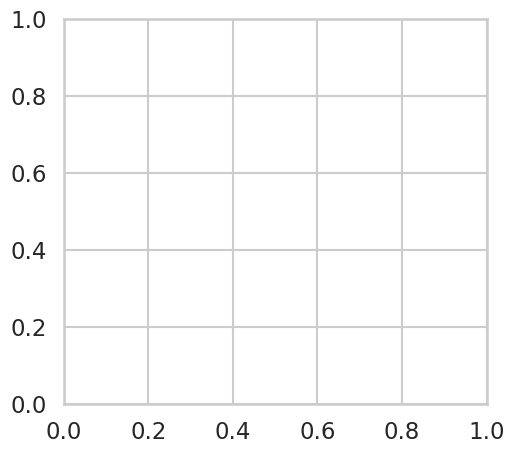

In [4]:
# NEW ERA

import tensorflow.keras.backend as K
import os
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0, MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC, Precision, Recall

# =============================================================================
# Define key parameters
# =============================================================================
img_size = 96         # We upscale FER images to 96x96
batch_size = 64       # Smaller batch size to avoid memory issues
epochs = 20           # Increase epochs, we'll use early stopping
model_type = "efficientnet"  # Options: "efficientnet", "mobilenet", "ensemble"

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure: root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
# Adjust this path to your actual data directory
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# =============================================================================
# 4. Data Visualization (Optional)
# =============================================================================
def plot_data_distribution():
    # Plot distribution of emotions by source
    plt.figure(figsize=(16, 6))
    
    # Combined
    plt.subplot(1, 3, 1)
    sns.countplot(x="label", data=train_df_full, palette="viridis")
    plt.title("Full Dataset Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # FER2013
    plt.subplot(1, 3, 2)
    sns.countplot(x="label", data=train_df_full[train_df_full["source"] == "fer2013"], palette="coolwarm")
    plt.title("FER2013 Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # AffectNet
    plt.subplot(1, 3, 3)
    sns.countplot(x="label", data=train_df_full[train_df_full["source"] == "affectnet"], palette="Spectral")
    plt.title("AffectNet Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize data distribution
# plot_data_distribution()

# =============================================================================
# 5. Optimized Data Generators
# =============================================================================
# Get emotion classes
classes = sorted(train_df_full["label"].unique())
print(f"Classes: {classes}")

# Define preprocessing functions
def preprocess_fer(img):
    """Convert grayscale to RGB and resize to target size"""
    # Convert to 3 channels by repeating the grayscale channel
    img = tf.image.grayscale_to_rgb(img)
    # Resize to target size
    img = tf.image.resize(img, [img_size, img_size], method='bicubic')
    return img / 255.0  # Normalize

def preprocess_affectnet(img):
    """Resize RGB image to target size"""
    img = tf.image.resize(img, [img_size, img_size])
    return img / 255.0  # Normalize

# Create training data generators
def create_generators():
    # Common augmentation parameters
    common_aug = {
        'horizontal_flip': True,
        'rotation_range': 20,
        'fill_mode': 'nearest'
    }
    
    # For FER2013 (grayscale)
    fer_datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        **common_aug
    )
    
    fer_train_gen = fer_datagen.flow_from_dataframe(
        dataframe=train_df[train_df["source"] == "fer2013"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=True
    )
    
    # For AffectNet (RGB)
    aff_datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.7, 1.3],
        **common_aug
    )
    
    aff_train_gen = aff_datagen.flow_from_dataframe(
        dataframe=train_df[train_df["source"] == "affectnet"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=True
    )
    
    # Validation generators - no augmentation
    val_datagen = ImageDataGenerator()
    
    fer_val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df[val_df["source"] == "fer2013"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    aff_val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df[val_df["source"] == "affectnet"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    return fer_train_gen, aff_train_gen, fer_val_gen, aff_val_gen

# Create test generator
def create_test_generator():
    test_datagen = ImageDataGenerator()
    
    # Split test data by source
    fer_test_df = test_df[test_df["source"] == "fer2013"]
    aff_test_df = test_df[test_df["source"] == "affectnet"]
    
    fer_test_gen = test_datagen.flow_from_dataframe(
        dataframe=fer_test_df,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    aff_test_gen = test_datagen.flow_from_dataframe(
        dataframe=aff_test_df,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    return fer_test_gen, aff_test_gen

fer_train_gen, aff_train_gen, fer_val_gen, aff_val_gen = create_generators()
fer_test_gen, aff_test_gen = create_test_generator()

# =============================================================================
# 6. Custom Data Generator that combines both sources
# =============================================================================
class CombinedGenerator:
    def __init__(self, fer_gen, aff_gen, batch_size=32):
        self.fer_gen = fer_gen
        self.aff_gen = aff_gen
        self.batch_size = batch_size
        self.n_classes = len(classes)
        self.fer_samples = len(fer_gen.filenames)
        self.aff_samples = len(aff_gen.filenames)
        self.total_samples = self.fer_samples + self.aff_samples
        
    def __len__(self):
        return (self.total_samples + self.batch_size - 1) // self.batch_size
    
    def __iter__(self):
        self.fer_iter = iter(self.fer_gen)
        self.aff_iter = iter(self.aff_gen)
        return self
    
    def __next__(self):
        # Randomly choose which generator to pull from based on dataset size ratio
        if np.random.random() < self.fer_samples / self.total_samples:
            try:
                batch_x, batch_y = next(self.fer_iter)
                # Convert grayscale to RGB
                if batch_x.shape[-1] == 1:
                    batch_x = np.repeat(batch_x, 3, axis=-1)
                return batch_x, batch_y
            except StopIteration:
                self.fer_iter = iter(self.fer_gen)
                return next(self)
        else:
            try:
                return next(self.aff_iter)
            except StopIteration:
                self.aff_iter = iter(self.aff_gen)
                return next(self)

# Create combined generators
train_gen = CombinedGenerator(fer_train_gen, aff_train_gen, batch_size)
val_gen = CombinedGenerator(fer_val_gen, aff_val_gen, batch_size)
test_gen = CombinedGenerator(fer_test_gen, aff_test_gen, batch_size)

# =============================================================================
# 7. Compute Class Weights for imbalanced dataset
# =============================================================================
def compute_class_weights(train_df):
    # Compute balanced class weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df["label"]),
        y=train_df["label"]
    )
    
    # Map class names to indices
    label_to_index = {label: i for i, label in enumerate(classes)}
    
    # Create dictionary of class weights
    weights_dict = {label_to_index[label]: weight 
                    for label, weight in zip(np.unique(train_df["label"]), class_weights)}
    
    return weights_dict

class_weights = compute_class_weights(train_df)
print("Class weights:", class_weights)

# =============================================================================
# 8. Model Architecture
# =============================================================================
def create_model(model_type="efficientnet"):
    input_tensor = Input(shape=(img_size, img_size, 3))
    
    if model_type == "efficientnet":
        # EfficientNetB0 without any extra preprocessing
        base_model = EfficientNetB0(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        # Freeze early layers
        for layer in base_model.layers[:100]:
            layer.trainable = False
        
        x = base_model.output
        
    elif model_type == "mobilenet":
        # MobileNetV3Small
        base_model = MobileNetV3Small(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        # Freeze early layers
        for layer in base_model.layers[:50]:
            layer.trainable = False
        
        x = base_model.output
        
    elif model_type == "ensemble":
        # Use both models
        efficient_base = EfficientNetB0(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        mobile_base = MobileNetV3Small(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        
        # Freeze early layers
        for layer in efficient_base.layers[:100]:
            layer.trainable = False
        for layer in mobile_base.layers[:50]:
            layer.trainable = False
        
        # Global pooling for both models
        efficient_features = GlobalAveragePooling2D()(efficient_base.output)
        mobile_features = GlobalAveragePooling2D()(mobile_base.output)
        
        # Concatenate features
        x = Concatenate()([efficient_features, mobile_features])
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Common head for all models
    if model_type != "ensemble":
        x = GlobalAveragePooling2D()(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(len(classes), activation="softmax")(x)
    
    model = Model(inputs=input_tensor, outputs=outputs)

    # Compile model with a fixed learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# Simplify model to verify training works
simple_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================================================
# 9. Training with callbacks
# =============================================================================

checkpoint_path = os.path.join("checkpoints", f"{model_type}_emotion_model.keras")
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

def train_model(model, train_generator, val_generator, epochs=20, class_weights=None):
    # Better learning rate schedule
    steps_per_epoch = len(train_generator)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,
        decay_steps=steps_per_epoch * epochs,
        alpha=1e-5
    )

    # Update the model's optimizer with the new learning rate schedule
    model.optimizer.learning_rate = lr_schedule  # Direct assignment

    checkpoint_path_keras = checkpoint_path + ".keras"

    # Callbacks
    callbacks = [
        # Save best model
        ModelCheckpoint(
            checkpoint_path,
            save_weights_only=False,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        # Early stopping
        EarlyStopping(
            monitor="val_accuracy",
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when plateau
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Calculate steps per epoch and validation steps
    steps_per_epoch = len(train_generator)
    validation_steps = len(val_generator)

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Train model
    start_time = time.time()
    try:
        history = model.fit(
            train_generator,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1
        )
    except Exception as e:
        print(f"Training error: {str(e)}")
        return None
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    return history

# =============================================================================
# 10. Evaluation
# =============================================================================
def evaluate_model(model, test_generator):
    # Calculate steps for test data
    test_steps = len(test_generator)
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Get predictions
    y_pred_probs = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Get true labels
    y_true = []
    for i in range(test_steps):
        try:
            _, batch_y = next(iter(test_generator))
            y_true.extend(np.argmax(batch_y, axis=1))
        except StopIteration:
            break
    
    # Limit to same size
    y_true = y_true[:len(y_pred)]
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=classes
    ))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred

# =============================================================================
# 11. Visualization Functions
# =============================================================================
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 12. Test on sample images
# =============================================================================
def test_on_samples(model, num_samples=3):
    plt.figure(figsize=(16, 12))
    
    # Get sample images from each class
    for i, emotion in enumerate(classes):
        # Get sample paths
        sample_paths = []
        fer_samples = test_df[(test_df['label'] == emotion) & (test_df['source'] == 'fer2013')]['filepath'].values
        aff_samples = test_df[(test_df['label'] == emotion) & (test_df['source'] == 'affectnet')]['filepath'].values
        
        if len(fer_samples) > 0:
            sample_paths.append(fer_samples[0])
        if len(aff_samples) > 0:
            sample_paths.append(aff_samples[0])
        
        # Limit to num_samples
        sample_paths = sample_paths[:num_samples]
        
        for j, img_path in enumerate(sample_paths):
            # Load and preprocess image
            color_mode = 'grayscale' if 'fer2013' in img_path else 'rgb'
            img = keras.preprocessing.image.load_img(
                img_path, 
                target_size=(img_size, img_size),
                color_mode=color_mode
            )
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            
            # Convert grayscale to RGB if needed
            if img_array.shape[-1] == 1:
                img_array = np.repeat(img_array, 3, axis=-1)
            
            # Add batch dimension
            img_batch = np.expand_dims(img_array, axis=0)
            
            # Predict
            predictions = model.predict(img_batch)
            predicted_class = classes[np.argmax(predictions[0])]
            confidence = np.max(predictions[0]) * 100
            
            # Plot
            plt_idx = i * num_samples + j + 1
            if plt_idx <= num_samples * len(classes):
                plt.subplot(len(classes), num_samples, plt_idx)
                plt.imshow(img_array)
                plt.title(f"True: {emotion}\nPred: {predicted_class}\nConf: {confidence:.1f}%")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN EXECUTION
# =============================================================================
def main():
    # Debug information
    print("Starting main function")
    print(f"Model type: {model_type}")
    
    try:
        # Create and train model
        model = create_model(model_type)
        print(f"Created {model_type} model")
    
        # Print model summary
        model.summary()
    
        # Train model
        history = train_model(
            model, 
            train_gen, 
            val_gen, 
            epochs=epochs, 
            class_weights=class_weights
        )
    
        # Plot training history
        plot_training_history(history)
        
        # Evaluate model
        y_true, y_pred = evaluate_model(model, test_gen)
        
        # Test on sample images
        test_on_samples(model)
        
        # Save final model
        model.save(f"final_{model_type}_emotion_model.keras")
        print(f"Model saved as final_{model_type}_emotion_model.keras")
        
        return model, history
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Mixed precision for faster training
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("Using mixed precision")
    except:
        print("Mixed precision not available")
    
    # Train model
    model, history = main()